In [ ]:
#@title Import libs, fundamental functions

"""
Utility functions and classes for Jupyter Notebooks lessons.
"""

!pip install flwr
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]

from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics, NDArrays, Scalar
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import logging
from flwr.common.logger import console_handler, log
from logging import INFO, ERROR


class InfoFilter(logging.Filter):
    def filter(self, record):
        return record.levelno == INFO


console_handler.setLevel(INFO)
console_handler.addFilter(InfoFilter())

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# To filter logging coming from the Simulation Engine
# so it's more readable in notebooks
from logging import ERROR
backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": False}}


class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x


def train_model(model, train_set):
    batch_size = 64
    num_epochs = 10

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


def evaluate_model(model, test_set):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = correct / total
    average_loss = total_loss / len(test_loader)
    # print(f"Test Accuracy: {accuracy:.4f}, Average Loss: {average_loss:.4f}")
    return average_loss, accuracy


def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def exclude_digits(dataset, excluded_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in excluded_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def compute_confusion_matrix(model, testset):
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test set to get predictions
    for image, label in testset:
        # Forward pass through the model to get predictions
        output = model(image.unsqueeze(0))  # Add batch dimension
        _, predicted = torch.max(output, 1)

        # Append true and predicted labels to lists
        true_labels.append(label)
        predicted_labels.append(predicted.item())

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Federated Training Process

#### Load imports

In [ ]:


from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Set up the training and testing datasets

* Set up the MNIST training datasets.

In [ ]:
trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform
)

total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])

train_sets = [part1, part2, part3]

* Set up the MNIST testing datasets.

In [ ]:
testset = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform
)
print("Number of examples in `testset`:", len(testset))

testset_137 = include_digits(testset, [1, 3, 7])
testset_258 = include_digits(testset, [2, 5, 8])
testset_469 = include_digits(testset, [4, 6, 9])

Number of examples in `testset`: 10000


#### Define training and testing in the pipeline

* Set functions for the client-server exchange of the training information.

In [ ]:
# Sets the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

* Connect the training in the pipeline using the Flower Client.

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset):
        self.net = net
        self.trainset = trainset
        self.testset = testset

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset)
        return get_weights(self.net), len(self.trainset), {}

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

* Flower calls `client_fn` whenever it needs an instance of one particular client to call fit or evaluate.

In [ ]:
# Client function
def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test).to_client()

* Create an instance of the ClientApp.

In [ ]:
client = ClientApp(client_fn)

* Define `evaluate` for testing.

The `evaluate` method evaluates the performance of the neural network model using the provided parameters and the test dataset (`testset`).

In [ ]:
def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)

    _, accuracy = evaluate_model(net, testset)
    _, accuracy137 = evaluate_model(net, testset_137)
    _, accuracy258 = evaluate_model(net, testset_258)
    _, accuracy469 = evaluate_model(net, testset_469)

    log(INFO, "test accuracy on all digits: %.4f", accuracy)
    log(INFO, "test accuracy on [1,3,7]: %.4f", accuracy137)
    log(INFO, "test accuracy on [2,5,8]: %.4f", accuracy258)
    log(INFO, "test accuracy on [4,6,9]: %.4f", accuracy469)

    if server_round == 3:
        cm = compute_confusion_matrix(net, testset)
        plot_confusion_matrix(cm, "Final Global Model")

* Strategy: Federated Average 'FedAvg'.

The federated averaging strategy (`strategy.FedAvg`) is created for federated learning.

In [ ]:
net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config=ServerConfig(num_rounds=3)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

* Create an instance of ServerApp.

In [ ]:
server = ServerApp(server_fn=server_fn)

* Start training.

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      test accuracy on all digits: 0.1267
INFO :      test accuracy on [1,3,7]: 0.2275
INFO :      test accuracy on [2,5,8]: 0.1201
INFO :      test accuracy on [4,6,9]: 0.0380
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sam

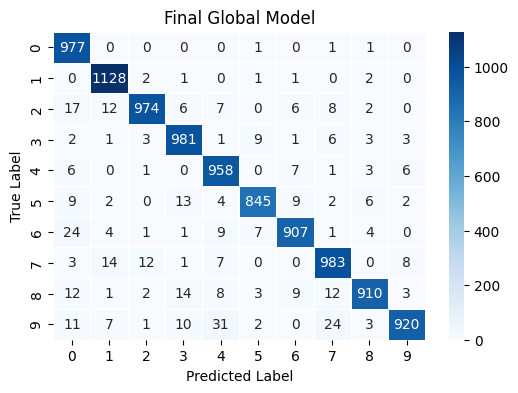

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 420.61s
INFO :      


In [ ]:
# Initiate the simulation passing the server and client apps
# Specify the number of super nodes that will be selected on every round
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
    backend_config=backend_setup,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
